In [13]:
import torch
import itertools
import numpy as np
from scipy.linalg import det
import time

def get_I_a_list(N):
    n = N//2
    I_list = list(itertools.combinations(range(1, N+1), 2))
    a_list = list(itertools.combinations(range(1, N+1), n))
    num_I = len(I_list)
    num_a = len(a_list)
    return I_list, a_list, num_I, num_a

N = 8
I_list, a_list, num_I, num_a = get_I_a_list(N)

# define various psi states
def psi_product_state(num_a):
    psi = torch.zeros(num_a)
    psi[0] = 1.
    return psi

def psi_random(num_a):
    psi = 2 * torch.rand(num_a) - 1.
    psi /= psi.norm()
    return psi

def psi_equal_superposition(num_a):
    psi = torch.ones(num_a)
    psi /= psi.norm()
    return psi
# check to see if this is the same as just rotating the product state 

# New psi states with varying entanglement
def psi_bell_like(num_a):
    """Bell-like state: highly entangled with strong correlations"""
    psi = torch.zeros(num_a)
    # Create a state with strong correlations between first and last half
    n = num_a // 2
    psi[:n] = torch.randn(n) * 0.1  # Small random component
    psi[n:] = psi[:n] * (-1)**torch.arange(n)  # Correlated with sign alternation
    psi[0] = 1.0  # Dominant component
    psi[n] = 1.0  # Correlated dominant component
    psi /= psi.norm()
    return psi

def psi_ghz_like(num_a):
    """GHZ-like state: maximally entangled with all components equal magnitude"""
    psi = torch.zeros(num_a)
    # Create a state where all components have equal magnitude but random phases
    phases = 2 * torch.pi * torch.rand(num_a)
    psi = torch.cos(phases) + 1j * torch.sin(phases)
    psi = psi.real  # Take real part for simplicity
    psi /= psi.norm()
    return psi

def psi_weakly_entangled(num_a):
    """Weakly entangled state: mostly product-like with small correlations"""
    psi = torch.zeros(num_a)
    psi[0] = 0.9  # Dominant component
    psi[1:] = torch.randn(num_a - 1) * 0.1  # Small random components
    psi /= psi.norm()
    return psi

def psi_moderately_entangled(num_a):
    """Moderately entangled state: balanced between product and maximally entangled"""
    psi = torch.zeros(num_a)
    # Create a state with several dominant components
    dominant_indices = torch.randperm(num_a)[:num_a//3]
    psi[dominant_indices] = torch.randn(len(dominant_indices))
    psi[~torch.isin(torch.arange(num_a), dominant_indices)] = torch.randn(num_a - len(dominant_indices)) * 0.3
    psi /= psi.norm()
    return psi

def psi_maximally_entangled(num_a):
    """Maximally entangled state: all components have equal weight"""
    psi = torch.ones(num_a)
    psi *= torch.sign(torch.randn(num_a))  # Random signs
    psi /= psi.norm()
    return psi

def psi_cluster_state_like(num_a):
    """Cluster state-like: highly entangled with specific correlation pattern"""
    psi = torch.zeros(num_a)
    # Create a state with strong nearest-neighbor correlations
    for i in range(0, num_a-1, 2):
        psi[i] = torch.randn(1)
        psi[i+1] = psi[i] * torch.sign(torch.randn(1))  # Correlated with random sign
    if num_a % 2 == 1:  # Handle odd case
        psi[-1] = torch.randn(1)
    psi /= psi.norm()
    return psi

def psi_w_state_like(num_a):
    """W-state-like: entangled state with specific excitation pattern"""
    psi = torch.zeros(num_a)
    # Create a state where excitation is distributed across several components
    excitation_indices = torch.randperm(num_a)[:num_a//4]
    psi[excitation_indices] = torch.ones(len(excitation_indices))
    psi /= psi.norm()
    return psi

psi = psi_random(num_a)

# Convert to tensors for vectorized processing
I_tensor = torch.tensor(I_list)  # (45, 2)
a_tensor = torch.tensor(a_list)  # (120, 3)

# Create empty tensor
J1 = torch.zeros((num_I, num_I, num_a))
J2 = torch.zeros((num_I, num_I, num_a))

# Levi-Civita sign function
def levi_civita_sign(big_set, sub_set):
    """
    Compute the sign of the permutation from sub_set + rest to big_set
    """
    perm = list(sub_set) + [x for x in big_set if x not in sub_set]
    idxs = [big_set.index(x) for x in perm]
    parity = np.array(idxs)
    sign = np.linalg.det(np.eye(len(parity))[parity])
    return int(round(sign))

def levi_civita_sign_optimized(big_set, sub_set):
    perm = list(sub_set) + [x for x in big_set if x not in sub_set]
    
    # Create a mapping from value to position
    value_to_pos = {val: pos for pos, val in enumerate(perm)}
    
    # Count cycles
    visited = [False] * len(perm)
    cycles = 0
    
    for i in range(len(perm)):
        if not visited[i]:
            cycles += 1
            j = i
            while not visited[j]:
                visited[j] = True
                j = value_to_pos[big_set[j]]
    
    # Sign is (-1)^(n - cycles) where n is the length
    return 1 if (len(perm) - cycles) % 2 == 0 else -1

def create_lookup_tables(I_list, a_list):
    """
    Create lookup tables to speed up set operations
    """
    # Precompute which I's are subsets of which a's
    I_subset_of_a = {}
    for i, I in enumerate(I_list):
        I_subset_of_a[i] = []
        for a_idx, a in enumerate(a_list):
            if set(I).issubset(set(a)):
                I_subset_of_a[i].append(a_idx)
    
    # Precompute Jp values (complements)
    Jp_values = {}
    for i, I in enumerate(I_list):
        for a_idx, a in enumerate(a_list):
            if set(I).issubset(set(a)):
                Jp = tuple(sorted(set(a) - set(I)))
                Jp_values[(i, a_idx)] = Jp
    
    return I_subset_of_a, Jp_values


def optimized_implementation_2(I_list, a_list, psi):
    num_I = len(I_list)
    num_a = len(a_list)
    
    # Convert to tensors for vectorized operations
    I_tensor = torch.tensor(I_list, dtype=torch.long)
    a_tensor = torch.tensor(a_list, dtype=torch.long)
    
    # Create sparse representation
    J1_data = []
    J1_indices = []
    J2_data = []
    J2_indices = []
    
    start_time = time.time()
    
    # Precompute all valid combinations
    valid_combinations = []
    for i, I in enumerate(I_list):
        for a_idx, a in enumerate(a_list):
            if set(I).issubset(set(a)):
                Jp = tuple(sorted(set(a) - set(I)))
                valid_combinations.append((i, a_idx, Jp))
    
    # Process valid combinations
    for i, a_idx, Jp in valid_combinations:
        for ip, ap_idx, Jpp in valid_combinations:
            if Jp == Jpp:
                a = a_list[a_idx]
                ap = a_list[ap_idx]
                I = I_list[i]
                Ip = I_list[ip]
                
                s1 = levi_civita_sign_optimized(a, I)
                s2 = levi_civita_sign_optimized(ap, Ip)
                
                J1_data.append(s1 * s2 * psi[ap_idx])
                J1_indices.append((i, ip, a_idx))
                
                J2_data.append(s1 * s2 * psi[a_idx])
                J2_indices.append((i, ip, ap_idx))
    
    # Convert to dense tensors
    J1 = torch.zeros((num_I, num_I, num_a))
    J2 = torch.zeros((num_I, num_I, num_a))
    
    for (i, ip, a_idx), val in zip(J1_indices, J1_data):
        J1[i, ip, a_idx] = val
    
    for (i, ip, ap_idx), val in zip(J2_indices, J2_data):
        J2[i, ip, ap_idx] = val
    
    end_time = time.time()
    print(f"Optimized implementation 2 time: {end_time - start_time:.4f} seconds")
    
    return J1, J2

# Optimized implementation 3: Memory-efficient processing
def optimized_implementation_3(I_list, a_list, psi, chunk_size=1000):
    num_I = len(I_list)
    num_a = len(a_list)
    
    J1 = torch.zeros((num_I, num_I, num_a))
    J2 = torch.zeros((num_I, num_I, num_a))
    
    # Create lookup tables
    I_subset_of_a, Jp_values = create_lookup_tables(I_list, a_list)
    
    start_time = time.time()
    
    # Process in chunks to reduce memory usage
    total_combinations = sum(len(I_subset_of_a[i]) for i in range(num_I))
    print(f"Total valid combinations: {total_combinations}")
    
    processed = 0
    for i in range(0, num_I, chunk_size):
        i_end = min(i + chunk_size, num_I)
        for ip in range(0, num_I, chunk_size):
            ip_end = min(ip + chunk_size, num_I)
            
            # Process this chunk
            for ii in range(i, i_end):
                for iip in range(ip, ip_end):
                    for a_idx in I_subset_of_a[ii]:
                        a = a_list[a_idx]
                        Jp = Jp_values[(ii, a_idx)]
                        
                        for ap_idx in I_subset_of_a[iip]:
                            ap = a_list[ap_idx]
                            Jpp = Jp_values[(iip, ap_idx)]
                            
                            if Jp == Jpp:
                                s1 = levi_civita_sign_optimized(a, I_list[ii])
                                s2 = levi_civita_sign_optimized(ap, I_list[iip])
                                J1[ii,iip,a_idx] += s1 * s2 * psi[ap_idx]
                                J2[ii,iip,ap_idx] += s1 * s2 * psi[a_idx]
                                processed += 1
    
    end_time = time.time()
    print(f"Optimized implementation 3 time: {end_time - start_time:.4f} seconds")
    print(f"Processed {processed} combinations")
    
    return J1, J2

# J1_opt, J2_opt = ultra_optimized_implementation(I_list, a_list, psi)
J1, J2 = optimized_implementation_2(I_list, a_list, psi)
# J1_opt3, J2_opt3 = optimized_implementation_3(I_list, a_list, psi)

# print(torch.allclose(J1_opt3, J1_opt2), torch.allclose(J2_opt3, J2_opt2))

#Main loop (vectorizable, but let's write clearly first)
# for i, I in enumerate(I_list):
#     for ip, Ip in enumerate(I_list):
#         for a_idx, a in enumerate(a_list):
#             if set(I).issubset(a):
#                 Jp = tuple(sorted(set(I) ^ set(a)))
#                 for ap_idx, ap in enumerate(a_list):
#                     if set(Ip).issubset(ap):
#                         Jpp = tuple(sorted(set(Ip) ^ set(ap)))
#                         if Jp == Jpp:
#                             s1 = levi_civita_sign_optimized(a, I)
#                             s2 = levi_civita_sign_optimized(ap, Ip)
#                             J1[i,ip,a_idx] += s1 * s2*psi[ap_idx]
#                             J2[i,ip,ap_idx] += s1 * s2*psi[a_idx]

# print(torch.allclose(J1, J1_opt), torch.allclose(J2, J2_opt))

Optimized implementation 2 time: 0.0904 seconds


In [14]:
import matplotlib.pyplot as plt
def plot_spectrum(S, threshold=1e-5):
    plt.figure(figsize=(6, 4))
    x_vals = np.arange(1, 1 + len(S))
    plt.semilogy(x_vals, S, 'o-')
    plt.xlabel('Singular value index')
    plt.ylabel('Singular value (log scale)')
    plt.title('Spectrum of Jacobian Matrix')

    # Show at most 10 ticks
    tick_count = min(len(S), 10)
    tick_locs = np.linspace(1, len(S), num=tick_count, dtype=int)
    plt.xticks(tick_locs)

    # Count number of singular values greater than threshold
    count_above_threshold = np.sum(S > threshold)

    # Add text in bottom-left
    plt.text(0.05, 0.05, f'rank: {count_above_threshold}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

    # Add horizontal dashed line at threshold
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1
                )

    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return count_above_threshold

torch.Size([784, 140])


/var/folders/kg/d0c6tmp54j5_s3jx3gs3bl6w0000gn/T/ipykernel_50022/138513940.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


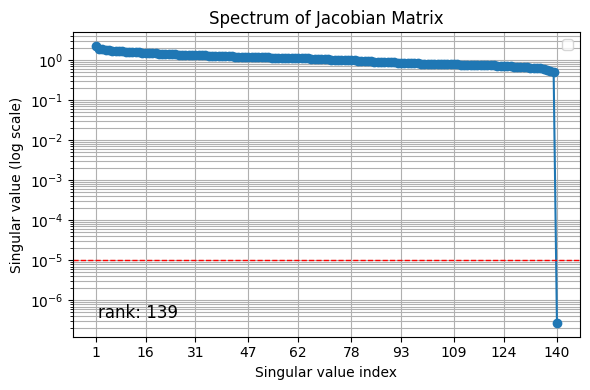

np.int64(139)

In [15]:
#J1 = torch.einsum('IJab,a -> IJb',k,psi)
#J1 -= torch.einsum('IJ,a -> IJa',rdm,psi)
J1 = J1.reshape(num_I**2,num_a)
#J2 = torch.einsum('IJab,b -> IJa',k,psi)
#J2 -= torch.einsum('IJ,a -> IJa',rdm,psi)
J2 = J2.reshape(num_I**2,num_a)
J = torch.cat((J1,J2),dim=1)
print(J.shape)
s = torch.linalg.svdvals(J)
plot_spectrum(np.array(s))